# risklearning demo

Most, if not all, operational risk capital models assume the existence of stationary frequency and severity distributions (typically Poisson for frequencies, and a subexponential distribution such as lognormal for severities). Yet every quarter (or whenever the model is recalibrated) risk capital goes up almost without fail, either because frequencies increase, severities increase or both.

The assumption of stationary distributions is just one limitation of current approaches to operational risk modeling, but it offers a good inroad for modeling approaches beyond the usual actuarial model typical in operational capital models.

In this notebook, we give a first example of how neural networks can overcome the stationarity assumptions of traditional approaches. The hope is that this is but one of many examples showing a better way to model operational risk.

Note: What follows if very much a work in progress . . .



In [1]:
import risklearning.learning_frequency as rlf

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

import ggplot as gg
%matplotlib inline

## Set up frequency distribution to generate samples

In [3]:
tenors_horizon = 365 # (Time) tenors (e.g. 1 day) per model horizon (e.g. 1 year)

h_start = 5.0 # How many model horizons of past data to train
h_end = 1.0 #How many model horizons of past data to test / validate

# Present is tenor 0, and boundary between training and testing data sets
t_start = -int(math.floor(h_start*tenors_horizon))
t_end = int(math.floor(h_end*tenors_horizon))


#% Generate Poisson-distributed events
lambda_init = 1 # intensity over tenor (e.g. day)
lambda_final = 4 # intensity over tenor (e.g. day)
n_tenors = t_end - t_start
lambda_ts = np.linspace(lambda_init, lambda_final, num=n_tenors)
freq_rv = stats.poisson
counts = rlf.sim_counts(lambda_ts, freq_rv)

# Build df around counts, level 1 and 2 categorization of Operational Risk events
l1s = ['Execution Delivery and Process Management']*n_tenors
l2s = ['Transaction Capture, Execution and Maintenance']*n_tenors
tenors = list(xrange(t_start, t_end))

counts_sim_df = pd.DataFrame({'t': tenors,
                              'OR Category L1': l1s, 'OR Category L2': l2s,
                              'counts': counts})


In [4]:
                    
#%% Do MLE (simple average for Poisson process
n_tenors_train = -t_start
n_tenors_test = t_end

counts_train = (counts_sim_df[counts_sim_df.t < 0]).groupby('OR Category L2').sum()
counts_test =  (counts_sim_df[counts_sim_df.t >= 0]).groupby('OR Category L2').sum()


## MLE for training data

For the Poisson distribution, the MLE of the intensity (here lambda) is just the average of the counts per model horizon. In practice, OpRisk models sometimes take a weighted average, with the weight linearly decreasing over a period of years (see e.g. "LDA at Work" by Aue and Kalkbrener).

In [5]:
lambdas_train = counts_train['counts']/n_tenors_train
lambdas_test = counts_train['counts']/n_tenors_test

bin_tops = [1,2,3,4,5,6,7,8,9,10,15,101]
# Recall that digitize (used later) defines bins by lower <= x < upper
count_tops =[count - 1 for count in bin_tops]

# Calculate bin probabilities from MLE poisson
poi_mle = stats.poisson(lambdas_train)
poi_bins = rlf.bin_probs(poi_mle, bin_tops)

mle_probs = pd.DataFrame({'Count Top': count_tops, 'Probs': poi_bins})
#mle_probs = pd.DataFrame(poi_bins, index = [t-1 for t in bin_tops], columns = ['Prob'])
mle_probs.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
Count Top,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,14.00000,1.000000e+02
Probs,0.105703,0.237527,0.266877,0.199902,0.112301,0.050471,0.018902,0.006068,0.001704,0.000426,0.00012,1.766285e-08


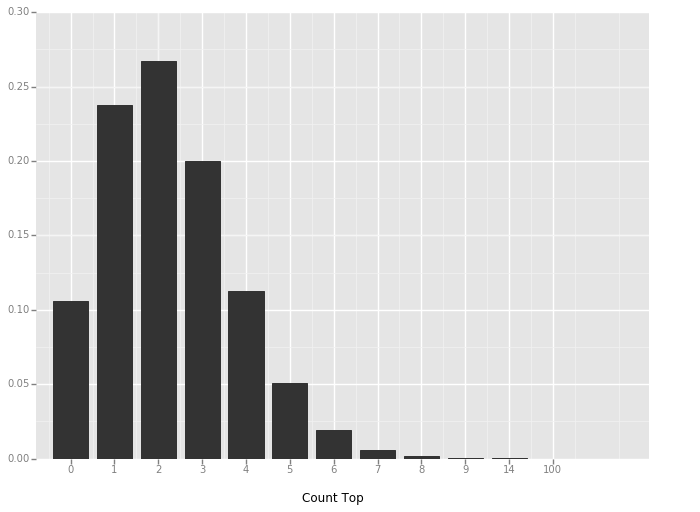

<ggplot: (8785865010137)>


In [6]:
mle_probs_vals = list(mle_probs.Probs)
# Visualize pdf (w.r.t. bins)
print gg.ggplot(mle_probs, gg.aes(x='Count Top',weight='Probs')) \
    + gg.geom_bar()


## Prep simulated losses for neural network

For example

* Use one-hot-encoding for L1 and L2 categories (this will make more sense once we look at multiple dependent categories)
* Bin count data
* Normalize tenors (i.e. scale so that first tenor maps to -1 with 0 preserved)
* Export as numpy arrays to feed into keras / tensorflow

In [7]:
import warnings
warnings.filterwarnings('ignore') # TODO: improve slicing to avoid warnings

x_train, y_train, x_test, y_test = rlf.prep_count_data(counts_sim_df, bin_tops)


## Set up the network architecture and train

We use keras with TensorFlow backend.

Note: there has been no real attempt yet to optimize metaparameters.

In [8]:
from keras.optimizers import SGD
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

rl_net = rlf.rl_train_net(x_train, y_train, x_test, y_test, [150], \
                    n_epoch = 200)


Using TensorFlow backend.


Train on 1825 samples, validate on 364 samples
Epoch 1/200
0s - loss: 1.8670 - val_loss: 2.1826
Epoch 2/200
0s - loss: 1.8072 - val_loss: 2.1874
Epoch 3/200
0s - loss: 1.7786 - val_loss: 2.1627
Epoch 4/200
0s - loss: 1.7634 - val_loss: 2.1414
Epoch 5/200
0s - loss: 1.7704 - val_loss: 2.1505
Epoch 6/200
0s - loss: 1.7677 - val_loss: 2.1644
Epoch 7/200
0s - loss: 1.7633 - val_loss: 2.1495
Epoch 8/200
0s - loss: 1.7652 - val_loss: 2.1424
Epoch 9/200
0s - loss: 1.7549 - val_loss: 2.1494
Epoch 10/200
0s - loss: 1.7591 - val_loss: 2.1189
Epoch 11/200
0s - loss: 1.7569 - val_loss: 2.1386
Epoch 12/200
0s - loss: 1.7616 - val_loss: 2.1300
Epoch 13/200
0s - loss: 1.7574 - val_loss: 2.1398
Epoch 14/200
0s - loss: 1.7581 - val_loss: 2.1415
Epoch 15/200
0s - loss: 1.7612 - val_loss: 2.1472
Epoch 16/200
0s - loss: 1.7584 - val_loss: 2.1406
Epoch 17/200
0s - loss: 1.7596 - val_loss: 2.1382
Epoch 18/200
0s - loss: 1.7508 - val_loss: 2.1401
Epoch 19/200
0s - loss: 1.7518 - val_loss: 2.1384
Epoch 20/200

## Neural network frequency distribution

If the neural network has learned anything, we will see that the probility distribution shifts over time to higher buckets.

In [9]:
proba = rl_net['probs_nn']



In [10]:
nn_probs = pd.DataFrame(proba, index = range(0,t_end-1), columns = [t-1 for t in bin_tops])
# Heads (i.e. starting from present)
nn_probs.head()

,0,1,2,3,4,5,6,7,8,9,14,100
0,0.030114,0.134587,0.175514,0.240642,0.157032,0.138755,0.073998,0.039967,0.005918,0.003265,0.000109,0.000098
1,0.030091,0.134560,0.175487,0.240683,0.157042,0.138773,0.074000,0.039976,0.005917,0.003264,0.000109,0.000098
2,0.030068,0.134532,0.175461,0.240723,0.157051,0.138792,0.074002,0.039985,0.005916,0.003263,0.000109,0.000098
3,0.030045,0.134504,0.175434,0.240764,0.157060,0.138810,0.074004,0.039995,0.005916,0.003261,0.000109,0.000098
4,0.030022,0.134480,0.175411,0.240806,0.157069,0.138825,0.074005,0.040002,0.005915,0.003260,0.000109,0.000098


In [11]:
# Tails (i.e. going to end of model horizon of 1 yr)
nn_probs.tail()

,0,1,2,3,4,5,6,7,8,9,14,100
359,0.023756,0.128853,0.173023,0.254962,0.159203,0.141370,0.071761,0.039442,0.005001,0.002517,0.000059,0.000053
360,0.023741,0.128839,0.173019,0.255001,0.159209,0.141377,0.071753,0.039438,0.004998,0.002515,0.000059,0.000053
361,0.023726,0.128826,0.173014,0.255040,0.159214,0.141383,0.071744,0.039434,0.004995,0.002513,0.000058,0.000053
362,0.023712,0.128812,0.173009,0.255078,0.159220,0.141390,0.071736,0.039429,0.004993,0.002511,0.000058,0.000053
363,0.023697,0.128797,0.173006,0.255118,0.159226,0.141396,0.071727,0.039424,0.004990,0.002509,0.000058,0.000052


In [12]:
# And what MLE told us before
mle_probs.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
Count Top,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,14.00000,1.000000e+02
Probs,0.105703,0.237527,0.266877,0.199902,0.112301,0.050471,0.018902,0.006068,0.001704,0.000426,0.00012,1.766285e-08


## Evaluating neural network
The above shows that the neural network learns

In [14]:
#% Convert proba from wide to long and append to other probs
# TODO: Missing last tenor in nn proba (already in x_test, y_test)
probs_list = []
kl_mle_list = []
kl_nn_list = []

for t in range(proba.shape[0]):
    nn_probs_t = proba[t]    
    true_bins_t = rlf.bin_probs(stats.poisson(lambda_ts[-t_start+t]), bin_tops)
    probs_t = pd.DataFrame({'Tenor': t, 'Count Top': count_tops, \
                            'Probs True': true_bins_t, \
                            'Probs NN': nn_probs_t, \
                            'Probs MLE': mle_probs_vals}, \
                            index = range(t*len(count_tops), \
                                    t*len(count_tops) + len(count_tops)))
    probs_list.append(probs_t)
    # Calculate KL divergences
    kl_mle_list.append(stats.entropy(true_bins_t, mle_probs_vals))
    kl_nn_list.append(stats.entropy(true_bins_t, nn_probs_t))

probs = pd.concat(probs_list)


     KL MLE     KL NN  Tenor
0  0.298380  0.024452      0
1  0.298987  0.024558      1
2  0.299595  0.024664      2
3  0.300204  0.024771      3
4  0.300813  0.024881      4
       KL MLE     KL NN  Tenor
359  0.549095  0.109899    359
360  0.549881  0.110275    360
361  0.550667  0.110651    361
362  0.551454  0.111028    362
363  0.552241  0.111410    363


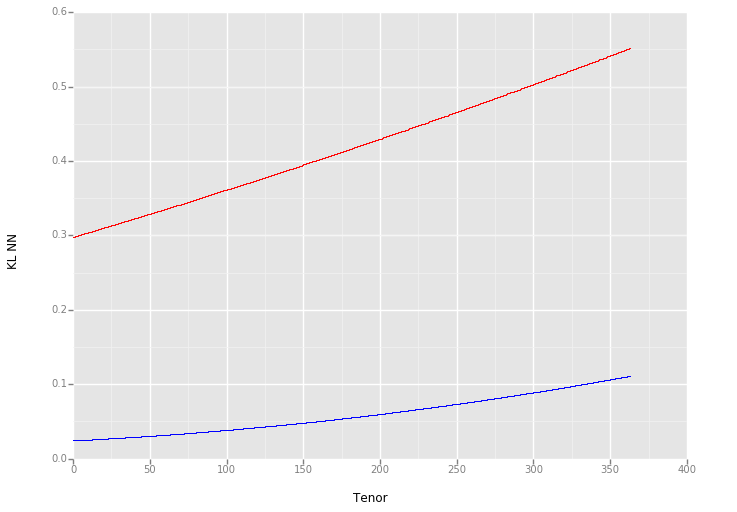

<ggplot: (8785812543785)>

In [15]:
# KL divergences
# TODO Why doesn't nn test data have last tenor?
kl_df = pd.DataFrame({'Tenor': range(0, t_end-1), \
                      'KL MLE': kl_mle_list, \
                      'KL NN': kl_nn_list})

print kl_df.head()

print kl_df.tail()                      
#%                      
# Plot KL divergences
gg.ggplot(kl_df, gg.aes(x='Tenor')) \
    + gg.geom_step(gg.aes(y='KL MLE', color = 'red')) \
    + gg.geom_step(gg.aes(y='KL NN', color = 'blue'))


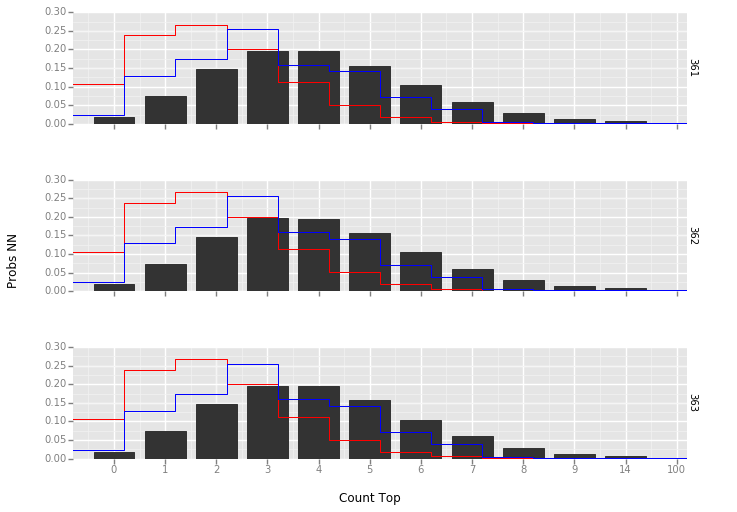

<ggplot: (8785811725653)>

In [17]:
probs_tail = probs[probs.Tenor > 360 ]

gg.ggplot(probs_tail, gg.aes(x='Count Top',weight='Probs True')) \
    + gg.facet_grid('Tenor') \
    + gg.geom_bar() \
    + gg.geom_step(gg.aes(y='Probs MLE', color = 'red')) \
    + gg.geom_step(gg.aes(y='Probs NN', color = 'blue')) \
    + gg.scale_x_continuous(limits = (0,len(count_tops)))



## Summary and next steps

We can see by the nn_probs data frame that the probability mass of the neural network shifts to the right, as does the underlying Poisson processes, with its intensity starting at 1 events per tenor / day at - 5 yrs and ending at 4 events per tenor / day at +1 yrs.

Next steps:

* Use better metric on generalization error that looking at probability tables (KS?)
* Optimize hyperparameters
* Simulate multiple, correlated Poisson processes
* Test non-linear non-stationarities
* Try recurrent neural network
* Try convolution network

